# LSI Word Embedding using K-means, Gaussian Mixture and Cosine Similarity as Clustering

In [1]:
import os.path

from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# from clustering_class import *
# from new_combine_models import *
# from DEC import *
# from generate_word_vector import *

from tqdm.notebook import tqdm, tnrange
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [2]:
pd.set_option('display.max_rows', 50)
plt.rcParams['figure.figsize'] = [17, 6]
plt.rcParams.update({'font.size': 12})

In [3]:
%%html
<style>
table {float:center}
</style>

# Read and Merge files

##### Ticker to GICS (version 1)

- data from prof (bloomberg)

In [ ]:
ticker_to_gics_df = pd.read_csv('data_out/ticker_to_gics_bloomberg.csv', index_col=0)
ticker_to_gics_df.Ticker = ticker_to_gics_df.Ticker.str.replace('/','-')
ticker_to_gics_df

##### Ticker to GICS (version 2)

- data from previous code (not sure where origin)
- more data

In [4]:
ticker_to_gics_df = pd.read_csv('data_in/ticker_to_gics.csv', names=['Ticker', 'GICS'])
ticker_to_gics_df.Ticker = ticker_to_gics_df.Ticker.str.replace('/','-')
ticker_to_gics_df.GICS = ticker_to_gics_df.GICS.apply(lambda x: str(x)[:6])
ticker_to_gics_df

,Ticker,GICS
0,A,352030
1,AA,151040
2,AAL,203020
3,AAN,255040
4,AAOI,452010
...,...,...
2959,ZTS,352020
2960,ZUMZ,255040
2961,ZUO,451030
2962,ZYNE,352020


##### SnP Descriptions (from 10K)

In [5]:
snp_desc_10K_df = pd.read_pickle('data_out/snp_desc_10K.pkl')

In [6]:
# [ticker for ticker in snp_desc_10K_df.Ticker if ticker not in list(ticker_to_gics_df.Ticker)]

In [7]:
snp_desc_10K_df = pd.merge(snp_desc_10K_df, ticker_to_gics_df, on='Ticker')
snp_desc_10K_df = snp_desc_10K_df[['Ticker', 'Description', 'GICS']]
snp_desc_10K_df.GICS = pd.Categorical(snp_desc_10K_df.GICS)

In [8]:
snp_desc_10K_df

,Ticker,Description,GICS
0,AAL,PART I ITEM 1. BUSINESS Overview American ...,203020
1,AAPL,PART I Item 1.Business Company Background T...,452020
2,AAP,PART I Item 1. Business. Unless the context ...,255040
3,ABBV,PART I ITEM 1. BUSINESS Overview AbbVie(1) ...,352010
4,ABC,PART I ITEM 1. BUSINESS As used herein the ...,351020
...,...,...,...
406,XYL,ITEM 1. BUSINESS Business Overview Xylem wi...,201060
407,YUM,PART I Item 1.Business. Yum! Brands Inc. (r...,253010
408,ZBH,PART I Item 1. Business Overview Zimm...,351010
409,ZION,ITEM 1. BUSINESS DESCRIPTION OF BUSINESS Zio...,401010


In [9]:
print(len(set(snp_desc_10K_df.GICS)))

60


In [ ]:
[t for t in snp_desc_10K_df.Ticker if t not in list(snp_desc_yahoo_df.Ticker)]

In [ ]:
[t for t in snp_desc_yahoo_df.Ticker if t not in list(snp_desc_10K_df.Ticker)]

- There seems to be alot of non-overlapping tickers in both snp data

##### SnP Descriptions (from yahoo)

In [46]:
snp_desc_yahoo_df = pd.read_csv('yahoo_spiders/data_out/snp_desc_yahoo.csv', ).dropna().reset_index(drop=True)

snp_desc_yahoo_df = pd.merge(snp_desc_yahoo_df, ticker_to_gics_df, on='Ticker')

snp_desc_yahoo_df.GICS = pd.Categorical(snp_desc_yahoo_df.GICS)
snp_desc_yahoo_df.Industry = pd.Categorical(snp_desc_yahoo_df.Industry)
snp_desc_yahoo_df.Sector = pd.Categorical(snp_desc_yahoo_df.Sector)

In [47]:
snp_desc_yahoo_df.head()

,Ticker,Description,Sector,Industry,GICS
0,ABBV,"AbbVie Inc. discovers, develops, manufactures,...",Healthcare,Drug Manufacturers—General,352010
1,MMM,"3M Company develops, manufactures, and markets...",Industrials,Specialty Industrial Machinery,201050
2,AMD,"Advanced Micro Devices, Inc. operates as a sem...",Technology,Semiconductors,453010
3,ABMD,"Abiomed, Inc. engages in the research, develop...",Healthcare,Medical Devices,351010
4,ABT,"Abbott Laboratories discovers, develops, manuf...",Healthcare,Medical Devices,351010


In [48]:
snp_desc_yahoo_df.shape

(439, 5)

In [49]:
print(len(set(snp_desc_yahoo_df.GICS)))
print(len(set(snp_desc_yahoo_df.Sector)))
print(len(set(snp_desc_yahoo_df.Industry)))

63
11
109


In [50]:
snp_desc_yahoo_df.iloc[1].Description

'3M Company develops, manufactures, and markets various products worldwide. It operates through four business segments: Safety and Industrial, Transportation and Electronics, Health Care, and Consumer. The Safety and Industrial segment offers personal safety products, industrial adhesives and tapes, abrasives, closure and masking systems, electrical markets, automotive aftermarket, and roofing granules to industrial, electrical, and safety markets. The Transportation and Electronics provides electronics, such as display materials and systems, electronic materials solutions; automotive and aerospace, and commercial solutions; advanced materials; and transportation safety products to transportation and electronic original equipment manufacturer customers. The Health Care segment offers medical and surgical supplies, skin health and infection prevention products, oral care, separation and purification sciences, health information systems, drug delivery systems, and food safety products to

##### Russell Descriptions (from 10K)

In [81]:
russell_desc_10K_df = pd.read_pickle('data_out/russell_desc_10K.pkl')

In [82]:
russell_desc_10K_df = pd.merge(russell_desc_10K_df, ticker_to_gics_df, on='Ticker')
russell_desc_10K_df = russell_desc_10K_df[['Ticker', 'Description', 'GICS']]
russell_desc_10K_df.GICS = pd.Categorical(russell_desc_10K_df.GICS)

In [83]:
russell_desc_10K_df

,Ticker,Description,GICS
0,AAL,PART I ITEM 1. BUSINESS Overview American ...,203020
1,AAN,PART I ITEM 1. BUSINESS Unless otherwise ind...,255040
2,AAOI,PART I Item 1. Business BUSINESS Overv...,452010
3,AAON,PART I Item 1. Business. General Development...,201020
4,AAPL,PART I Item 1.Business Company Background T...,452020
...,...,...,...
2823,ZUMZ,Item 1. BUSINESS Zumiez Inc. including i...,255040
2824,ZUO,PART I Item 1. Business Overview Zuora is a...,451030
2825,ZYNE,PART I Item 1. Business Unless the con...,352020
2826,ZYXI,PART I ITEM 1. BUSINESS History Zynex I...,351010


In [84]:
print(len(set(russell_desc_10K_df.GICS)))

69


##### Russell Descriptions (from yahoo)

In [115]:
russell_desc_yahoo_df = pd.read_csv('yahoo_spiders/data_out/russell_desc_yahoo.csv', ).dropna().reset_index(drop=True)

russell_desc_yahoo_df = pd.merge(russell_desc_yahoo_df, ticker_to_gics_df, on='Ticker')

russell_desc_yahoo_df.GICS = pd.Categorical(russell_desc_yahoo_df.GICS)
russell_desc_yahoo_df.Industry = pd.Categorical(russell_desc_yahoo_df.Industry)
russell_desc_yahoo_df.Sector = pd.Categorical(russell_desc_yahoo_df.Sector)

In [116]:
russell_desc_yahoo_df

,Ticker,Description,Sector,Industry,GICS
0,A,"Agilent Technologies, Inc. provides applicatio...",Healthcare,Diagnostics & Research,352030
1,AAL,"American Airlines Group Inc., through its subs...",Industrials,Airlines,203020
2,AAON,"AAON, Inc., together with its subsidiaries, en...",Industrials,Building Products & Equipment,201020
3,AAP,"Advance Auto Parts, Inc. provides automotive r...",Consumer Cyclical,Specialty Retail,255040
4,AAN,"Aaron's, Inc. operates as an omnichannel provi...",Industrials,Rental & Leasing Services,255040
...,...,...,...,...,...
2067,ZIXI,"Zix Corporation provides email encryption, dat...",Technology,Software—Infrastructure,451030
2068,ZTS,"Zoetis Inc. discovers, develops, manufactures,...",Healthcare,Drug Manufacturers—Specialty & Generic,352020
2069,ZUMZ,"Zumiez Inc., together with its subsidiaries, o...",Consumer Cyclical,Apparel Retail,255040
2070,ZYNE,"Zynerba Pharmaceuticals, Inc. operates as a cl...",Healthcare,Drug Manufacturers—Specialty & Generic,352020


In [117]:
russell_desc_yahoo_df.shape

(2072, 5)

In [118]:
print(len(set(russell_desc_yahoo_df.GICS)))
print(len(set(russell_desc_yahoo_df.Sector)))
print(len(set(russell_desc_yahoo_df.Industry)))

68
11
141


### Global Vars: Tickers, Description, Classifier to be used

In [119]:
desc_df = russell_desc_yahoo_df
desc_list = desc_df['Description']
NUM_INDUSTRIES =  len(set(desc_df.GICS))#69

print(NUM_INDUSTRIES)

68


##### Pre Processing

In [120]:
def preprocess_data(doc_list):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))# create English stop words list
    p_stemmer = PorterStemmer()
    processed_doc_list = []

    for doc in doc_list:
        lower_doc = doc.lower()
        token_list = tokenizer.tokenize(lower_doc)
        stopped_token_list = [i for i in token_list if not i in en_stop]
        stemmed_token_list = [p_stemmer.stem(i) for i in stopped_token_list]
        processed_doc = ' '.join(stemmed_token_list) # Untokenize
        processed_doc_list.append(processed_doc)
    
    return processed_doc_list

In [121]:
preped_desc_list = preprocess_data(desc_list)

In [122]:
len(preped_desc_list)

2072

##### Tdidf vectorization

In [123]:
vectorizer = TfidfVectorizer(stop_words='english', max_features= None, max_df = 0.5, smooth_idf=True)
dtm = vectorizer.fit_transform(preped_desc_list) # dtm - Document Matrix (sparse matrix)
dtm.shape

(2072, 16855)

| Descriptions | Unique Words (features)
| :- | -: | 
| SnP (10K) | 25834 |
| SnP (yahoo) | 7263 |
| Russell (10K) | 78546 |
| Russell (yahoo) | 16855 |
| Russell (10K, from previous project) | 20025 |




# Clustering Algos

### K - Means

In [ ]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=NUM_INDUSTRIES, init='k-means++')
# fitting the k means algorithm on scaled data
kmeans.fit(dtm_lsa)
pred = kmeans.predict(dtm_lsa)
# pd.concat([df[['company']], pd.DataFrame(pred)], axis=1).head()
pred

In [16]:
def kmeans_cluster(dtm):
    '''
    input: Document Matrix
    output: list indicating clusters
    '''
    kmeans = KMeans(n_clusters=NUM_INDUSTRIES, init='k-means++')
    kmeans.fit(dtm)
    pred = kmeans.predict(dtm)
    return pred

### Gaussian Mixture

In [17]:
def gmm_cluster(dtm):
    '''
    input: Document Matrix
    output: list indicating clusters
    '''
    gmm = GaussianMixture(n_components=NUM_INDUSTRIES)
    gmm.fit(dtm)
    pred = gmm.predict(dtm)
    return pred

### Cosine Similarity

- taking too long to run

In [ ]:
x = [((1,),(2,),3), ((4,),(1458,),6)]

mcorr = ((1458,), (1830,), 1.0000000000000004)
list(filter(lambda tup: (tup[0] not in mcorr) and (tup[1] not in mcorr), x))

In [ ]:
((1,2), (4,)) in (1,)

In [ ]:
def cosine_similarity(dtm):
    '''
    input: Doc Matrix
    output: list of lists indicating clusters
    '''
    corr = np.asarray(np.asmatrix(dtm) * np.asmatrix(dtm).T)
    L = corr.shape[0]
    
    cluster_corrs = []
    for i in range(L):
        for j in range(i+1,L):
            corr_tuple = ((i,), (j,), corr[i][j])
            cluster_corrs.append(corr_tuple)
            
    cluster_list = [(i,) for i in range(L)]
    
    num_iter = L - NUM_INDUSTRIES
    for x in range(num_iter):
        max_corr_tup = max(cluster_corrs, key = lambda tup: tup[2])
        # filters ur max_corr_tup also
        print(max_corr_tup)
        cluster_corrs = list(filter(lambda tup: (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup),cluster_corrs))
        new_cluster = max_corr_tup[0] + max_corr_tup[1] # concatenate tups
        cluster_list.remove(max_corr_tup[0])
        cluster_list.remove(max_corr_tup[1])
        for cluster in cluster_list:
            # Similarity
            n = len(new_cluster) * len(cluster)
            total_similarity = 0
            for cpy_1 in new_cluster:
                for cpy_2 in cluster:
                    total_similarity += corr[cpy_1][cpy_2]
            similarity = total_similarity / n
            corr_tuple = (new_cluster, cluster, similarity)
            cluster_corrs.append(corr_tuple)
        cluster_list.append(new_cluster)
    
    if len(cluster_list) != NUM_INDUSTRIES:
        raise Exception()
        
    pred = np.full(N, -1)
    for i in range(NUM_INDUSTRIES):
        cluster = list(cluster_list[i])
        pred[cluster] = [i] * len(cluster)
    return pred

In [ ]:
cosine_similarity(dtm_lsa)

In [ ]:
dtmx = dtm_lsa
corr = np.asarray(np.asmatrix(dtmx) * np.asmatrix(dtmx).T)
L = corr.shape[0]

cluster_corrs = []
for i in range(L):
    for j in range(i+1,L):
        corr_tuple = ((i,), (j,), corr[i][j])
        cluster_corrs.append(corr_tuple)

cluster_list = [(i,) for i in range(L)]

num_iter = L - NUM_INDUSTRIES
for x in range(num_iter):
    max_corr_tup = max(cluster_corrs, key = lambda tup: tup[2])
    # filters ur max_corr_tup also
    print(max_corr_tup)
    cluster_corrs = list(filter(lambda tup: (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup),cluster_corrs))
    new_cluster = max_corr_tup[0] + max_corr_tup[1] # concatenate tups
    cluster_list.remove(max_corr_tup[0])
    cluster_list.remove(max_corr_tup[1])
    for cluster in cluster_list:
        # Similarity
        n = len(new_cluster) * len(cluster)
        total_similarity = 0
        for cpy_1 in new_cluster:
            for cpy_2 in cluster:
                total_similarity += corr[cpy_1][cpy_2]
        similarity = total_similarity / n
        corr_tuple = (new_cluster, cluster, similarity)
        cluster_corrs.append(corr_tuple)
    cluster_list.append(new_cluster)

if len(cluster_list) != NUM_INDUSTRIES:
    raise Exception()

pred = np.full(N, -1)
for i in range(NUM_INDUSTRIES):
    cluster = list(cluster_list[i])
    pred[cluster] = [i] * len(cluster)

In [ ]:
def t(tup):
    print((tup[0] not in max_corr_tup), (tup[1] not in max_corr_tup))
    return (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup)
list(filter(t,cluster_corrs))

### Run all Clustering algos

In [124]:
dtm.shape

(2072, 16855)

In [125]:
gics_df = pd.DataFrame(desc_df.GICS.cat.codes, columns=['GICS'])
cluster_dfs_list = [desc_df[['Ticker']], gics_df]
for k in tnrange(50, 401, 50):
    # LSI Embedding
    lsa_k = TruncatedSVD(k, algorithm = 'arpack')
    dtm_lsa_k = lsa_k.fit_transform(dtm)
    dtm_lsa_k = Normalizer(copy=False).fit_transform(dtm_lsa_k)
    # K-Means
    clusters_k = kmeans_cluster(dtm_lsa_k)
    cluster_dfs_list.append(pd.DataFrame(clusters_k, columns=['lsi_{}_kmeans'.format(str(k))]))
    # GMM
    clusters_k = gmm_cluster(dtm_lsa_k)
    cluster_dfs_list.append(pd.DataFrame(clusters_k, columns=['lsi_{}_gmm'.format(str(k))]))
    # Cosine_similarity
    
all_cluster = pd.concat(cluster_dfs_list, axis=1)

In [126]:
all_cluster

,Ticker,GICS,lsi_50_kmeans,lsi_50_gmm,lsi_100_kmeans,lsi_100_gmm,lsi_150_kmeans,lsi_150_gmm,lsi_200_kmeans,lsi_200_gmm,lsi_250_kmeans,lsi_250_gmm,lsi_300_kmeans,lsi_300_gmm,lsi_350_kmeans,lsi_350_gmm,lsi_400_kmeans,lsi_400_gmm
0,A,42,14,31,34,2,35,27,3,55,23,48,57,43,42,2,50,56
1,AAL,17,0,17,58,36,48,30,29,4,50,45,34,58,49,42,11,45
2,AAON,8,25,41,12,4,66,50,14,64,62,64,53,38,24,41,20,7
3,AAP,30,5,58,48,61,46,5,4,64,29,14,53,38,46,53,36,29
4,AAN,30,43,16,50,59,29,39,0,9,22,27,38,14,61,1,51,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,ZIXI,51,41,26,44,54,9,15,5,16,41,17,25,24,57,58,8,53
2068,ZTS,41,14,31,34,2,19,27,3,31,67,48,57,43,38,32,53,56
2069,ZUMZ,30,29,16,13,39,47,38,65,21,54,26,4,30,65,22,6,57
2070,ZYNE,41,17,11,17,10,65,4,36,54,3,13,21,13,13,67,2,46


## Evaluation

### Method 1 - Ticker returns correlations

- regression of the daily return series of each stock with the return of the industry that the stock belongs to
- criterion is the the average of all R2s from the universe
- 5 years of daily returns used (same as previous project)

In [127]:
ticker_price_df = pd.read_csv('data_in/russell_price.csv', index_col=0) 
# Can use this path for SnP: 'data_out/ticker_price_df.csv'

In [128]:
ticker_price_df.columns = ticker_price_df.columns.str.replace('/', '-')
ticker_return_df = ticker_price_df.pct_change()
ticker_return_df

,A,AA,AAL,AAN,AAOI,AAON,AAP,AAPL,AAT,AAWW,...,ZION,ZIOP,ZIXI,ZNGA,ZS,ZTS,ZUMZ,ZUO,ZYNE,ZYXI
20150102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20150105,-0.018737,-0.057933,-0.000650,-0.003919,-0.012975,-0.033973,-0.013177,-0.028175,0.011396,-0.036555,...,-0.037468,-0.011696,-0.019718,-0.007326,1.062500,-0.006004,0.019105,0.428571,0.160714,-0.111803
20150106,-0.015577,0.007351,-0.015498,-0.037378,-0.037559,-0.015815,-0.000704,0.000093,0.007836,-0.021222,...,-0.038192,-0.021696,-0.025862,-0.003690,-0.154545,-0.009754,-0.012327,0.030000,0.188923,-0.062550
20150107,0.013273,0.025880,-0.000565,0.030317,-0.039024,0.009115,0.021485,0.014021,0.018955,0.017959,...,0.009356,0.012097,-0.002950,-0.007407,0.088889,0.020642,0.047322,0.000000,0.270186,-0.020018
20150108,0.029974,0.028461,0.012260,0.016196,0.011168,0.024715,0.008769,0.038426,0.005963,0.037220,...,0.014184,-0.005976,0.076923,-0.037313,0.023041,0.015398,0.027805,-0.050971,0.431948,-0.013616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200518,0.025371,0.171171,0.091814,0.066134,0.024540,0.069529,0.040060,0.023561,0.066448,0.084015,...,0.119171,0.102041,0.032833,-0.009950,0.000000,0.030826,0.087572,0.000000,0.000000,0.000000
20200519,-0.020201,-0.007692,-0.023303,-0.032964,0.010778,-0.022518,0.035924,-0.005779,-0.034615,0.007802,...,-0.033730,-0.074074,0.019074,0.010050,0.000000,0.022219,-0.034716,0.000000,0.000000,0.000000
20200520,-0.003172,0.078811,0.023859,0.046173,0.020142,0.008213,-0.000736,0.019448,0.028287,0.028645,...,0.065024,0.080000,0.074866,0.012438,0.000000,-0.007444,-0.000999,0.000000,0.000000,0.000000
20200521,-0.011749,-0.008383,0.002026,-0.001777,0.005807,0.029009,-0.006852,-0.007455,0.004649,-0.006774,...,-0.012532,0.047138,0.023217,-0.000614,0.000000,-0.022574,0.092000,0.000000,0.000000,0.000000


In [129]:
# Tickers to remove if no ticker data
tickers_with_no_data = [ticker for ticker in all_cluster.Ticker if ticker not in ticker_return_df.columns]
print(tickers_with_no_data)

[]


In [130]:
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)
all_cluster_filtered.head()

,Ticker,GICS,lsi_50_kmeans,lsi_50_gmm,lsi_100_kmeans,lsi_100_gmm,lsi_150_kmeans,lsi_150_gmm,lsi_200_kmeans,lsi_200_gmm,lsi_250_kmeans,lsi_250_gmm,lsi_300_kmeans,lsi_300_gmm,lsi_350_kmeans,lsi_350_gmm,lsi_400_kmeans,lsi_400_gmm
0,A,42,14,31,34,2,35,27,3,55,23,48,57,43,42,2,50,56
1,AAL,17,0,17,58,36,48,30,29,4,50,45,34,58,49,42,11,45
2,AAON,8,25,41,12,4,66,50,14,64,62,64,53,38,24,41,20,7
3,AAP,30,5,58,48,61,46,5,4,64,29,14,53,38,46,53,36,29
4,AAN,30,43,16,50,59,29,39,0,9,22,27,38,14,61,1,51,31


In [131]:
R2_dict = {}

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    
    R2_list = []
    for i in range(NUM_INDUSTRIES):
        cluster_tickers = all_cluster_filtered[all_cluster_filtered[cluster_mtd] == i].Ticker
        cluster_ticker_returns = ticker_return_df[cluster_tickers]
        mean_return = cluster_ticker_returns.mean(axis=1)
        cluster_R2 = [mean_return.corr(ticker_returns) for _, ticker_returns in cluster_ticker_returns.iteritems()]
        R2_list.extend(cluster_R2)
    avg_R2 = sum(R2_list)/len(R2_list)
    R2_dict[cluster_mtd] = avg_R2

avg_R2_df = pd.DataFrame.from_dict(R2_dict, orient='index', columns=['Average R2'])

In [132]:
GICS_R2 = R2_dict['GICS']
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = avg_R2_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd]  #(columns = {'test':'TEST'}, inplace = True) 
    list_of_dfs.append(mtd_df)

avg_R2_pivot_df = pd.concat(list_of_dfs, axis=1)
print(GICS_R2)
avg_R2_pivot_df

0.5390955173193318


,kmeans,gmm
50,0.545376,0.544600
100,0.537682,0.537158
150,0.544405,0.544511
200,0.540864,0.543550
250,0.544499,0.535519
300,0.540311,0.545846
350,0.543500,0.546790
400,0.539665,0.547992


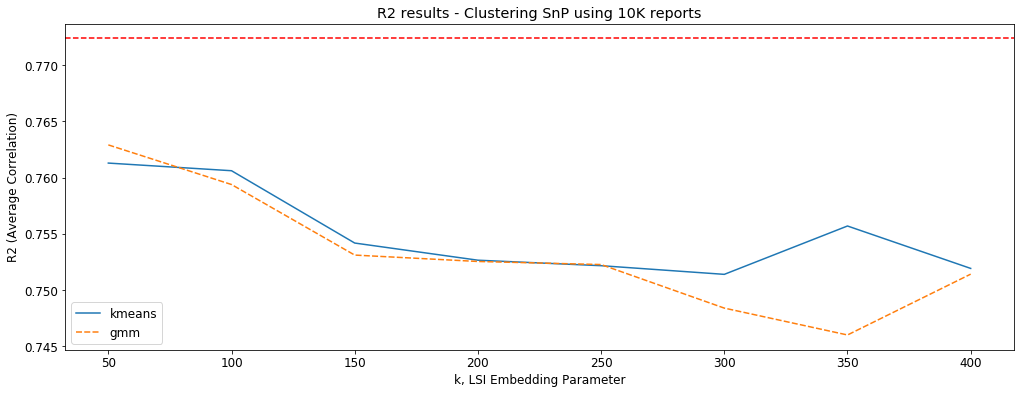

In [29]:
ax = sns.lineplot(data=avg_R2_pivot_df, sort=False)
ax.axhline(GICS_R2, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title='R2 results - Clustering SnP using 10K reports')
plt.savefig('data_out/images/1_1.png')

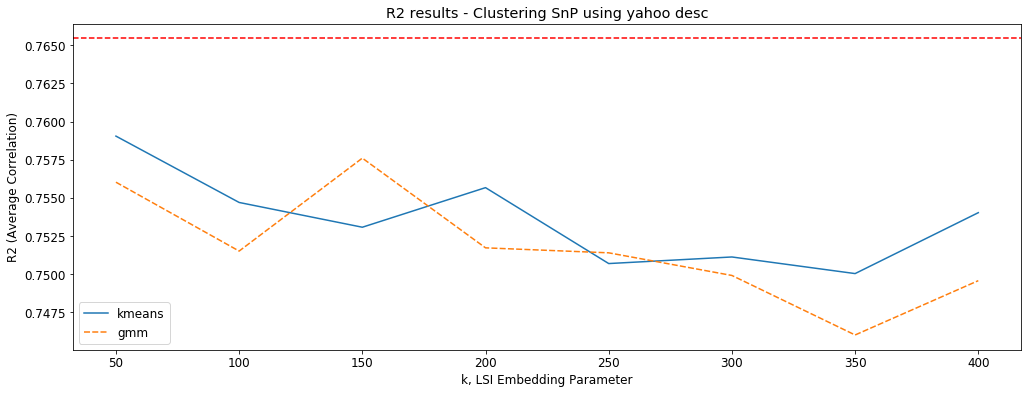

In [65]:
ax = sns.lineplot(data=avg_R2_pivot_df, sort=False)
ax.axhline(GICS_R2, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title='R2 results - Clustering SnP using yahoo desc')
plt.savefig('data_out/images/1_2.png')

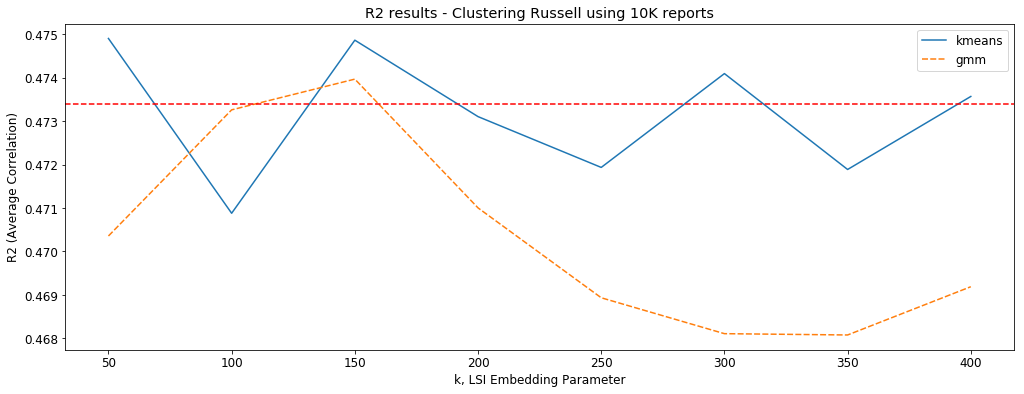

In [99]:
ax = sns.lineplot(data=avg_R2_pivot_df, sort=False)
ax.axhline(GICS_R2, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title='R2 results - Clustering Russell using 10K reports')
plt.savefig('data_out/images/1_3.png')

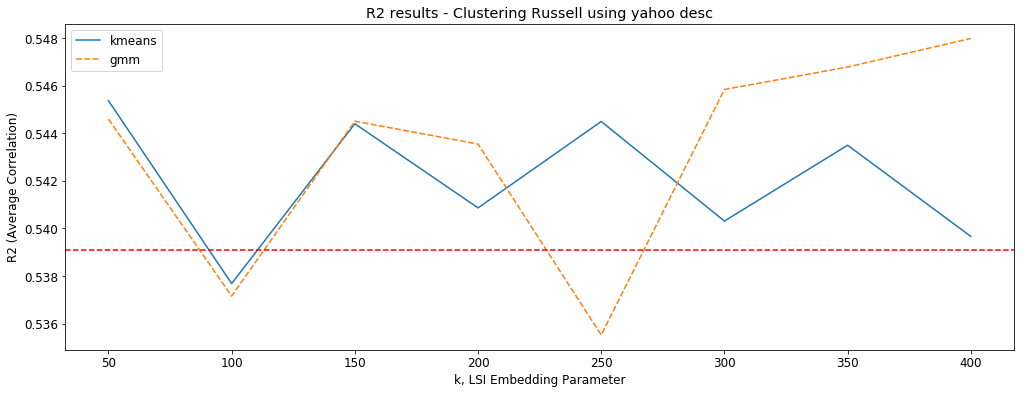

In [133]:
ax = sns.lineplot(data=avg_R2_pivot_df, sort=False)
ax.axhline(GICS_R2, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title='R2 results - Clustering Russell using yahoo desc')
plt.savefig('data_out/images/1_4.png')

### Method 2a - Inter Industry Variation of firm ratios

- The second criterion used is the across-industry variation (Hoberg and Phillips)
- Need to handle missing values of ratios
- in previous paper they removed outlier so higher score
- The higher the score the better

In [134]:
ticker_ratios_df = pd.read_csv('data_in/russell_ratios.csv')

In [135]:
def percentage_to_float(s):
    if type(s) == float:
        return s
    return float(s.strip('%').replace(',',''))/100

def mkt_cap_converter(s):
    if type(s) == float:
        return s
    multiplier = s[-1]
    if multiplier == 'M':
        return float(s[:-1])* 1000
    if multiplier == 'B':
        return float(s[:-1]) * 1000
    if multiplier == 'T':
        return float(s[:-1]) * 1000000
    else:
        raise Exception(s)
        
def pb_ratio_converter(s):
    if type(s) == float:
        return s
    multiplier = s[-1]
    if multiplier == 'k':
        return float(s[:-1]) * 1000
    else:
        return float(s)
    
def remove_commas(s):
    if type(s) == float:
        return s
    return float(s.replace(',',''))

In [136]:
ticker_ratios_df.columns = ['Ticker', 'mkt_cap', 'pb_ratio', 'beta', 'profit_margin', 'ROA', 'ROE']

ticker_ratios_df.mkt_cap = ticker_ratios_df.mkt_cap.apply(mkt_cap_converter)
ticker_ratios_df.pb_ratio = ticker_ratios_df.pb_ratio.apply(pb_ratio_converter)
ticker_ratios_df.beta = ticker_ratios_df.beta.apply(remove_commas)
ticker_ratios_df.profit_margin = ticker_ratios_df.profit_margin.apply(percentage_to_float)
ticker_ratios_df.ROA = ticker_ratios_df.ROA.apply(percentage_to_float)
ticker_ratios_df.ROE = ticker_ratios_df.ROE.apply(percentage_to_float)

ticker_ratios_df

,Ticker,mkt_cap,pb_ratio,beta,profit_margin,ROA,ROE
0,MMM,78520.0,7.80,1.00,0.1537,0.1040,0.4992
1,ABT,139580.0,4.49,0.97,0.1115,0.0459,0.1156
2,ABBV,112510.0,NaN,0.78,0.2477,0.1180,NaN
3,ABMD,6530.0,6.24,0.86,0.2414,0.1372,0.2028
4,ACN,114850.0,7.59,1.03,0.1113,0.1344,0.3401
...,...,...,...,...,...,...,...
2886,PMT,1060.0,0.49,1.09,0.0000,-0.0433,-0.2376
2887,COLL,560220.0,6.41,1.07,-0.0421,-0.0117,-0.1106
2888,FLIC,412810.0,1.06,0.52,0.3688,0.0096,0.1045
2889,GWR,6300.0,1.81,1.31,0.0928,0.0308,0.0580


In [137]:
# ticker_ratios_df = pd.read_csv('data_out/snp_ratios_df.csv', index_col=0)
# ticker_ratios_df

In [138]:
# Normalise values
ticker_ratios_normalised_df = ticker_ratios_df.copy()
# for header in ticker_ratios_df.columns[1:]:
#     col = ticker_ratios_df[header]
#     ticker_ratios_normalised_df[header] = (col - col.mean())/col.std()
ticker_ratios_normalised_df

,Ticker,mkt_cap,pb_ratio,beta,profit_margin,ROA,ROE
0,MMM,78520.0,7.80,1.00,0.1537,0.1040,0.4992
1,ABT,139580.0,4.49,0.97,0.1115,0.0459,0.1156
2,ABBV,112510.0,NaN,0.78,0.2477,0.1180,NaN
3,ABMD,6530.0,6.24,0.86,0.2414,0.1372,0.2028
4,ACN,114850.0,7.59,1.03,0.1113,0.1344,0.3401
...,...,...,...,...,...,...,...
2886,PMT,1060.0,0.49,1.09,0.0000,-0.0433,-0.2376
2887,COLL,560220.0,6.41,1.07,-0.0421,-0.0117,-0.1106
2888,FLIC,412810.0,1.06,0.52,0.3688,0.0096,0.1045
2889,GWR,6300.0,1.81,1.31,0.0928,0.0308,0.0580


In [139]:
# Tickers to remove if no ratio data
tickers_with_no_data = [ticker for ticker in all_cluster.Ticker if ticker not in list(ticker_ratios_df.Ticker)]
print(tickers_with_no_data)

['ADPT', 'ARNC', 'AVTR', 'BEAM', 'CE', 'LB', 'NOVA', 'PPD', 'STSA']


In [140]:
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)
all_cluster_filtered.head()

,Ticker,GICS,lsi_50_kmeans,lsi_50_gmm,lsi_100_kmeans,lsi_100_gmm,lsi_150_kmeans,lsi_150_gmm,lsi_200_kmeans,lsi_200_gmm,lsi_250_kmeans,lsi_250_gmm,lsi_300_kmeans,lsi_300_gmm,lsi_350_kmeans,lsi_350_gmm,lsi_400_kmeans,lsi_400_gmm
0,A,42,14,31,34,2,35,27,3,55,23,48,57,43,42,2,50,56
1,AAL,17,0,17,58,36,48,30,29,4,50,45,34,58,49,42,11,45
2,AAON,8,25,41,12,4,66,50,14,64,62,64,53,38,24,41,20,7
3,AAP,30,5,58,48,61,46,5,4,64,29,14,53,38,46,53,36,29
4,AAN,30,43,16,50,59,29,39,0,9,22,27,38,14,61,1,51,31


<font size="5">
$$
\sigma_v = \frac
                {\sqrt{\sum_{i=0}^{N} n_i \frac{v_m - v_i}{N}}}
                {\sqrt{\sum_{j=0}^{F} \frac{v_m - f_j}{N}}            }
$$
</font>

- $N$ - num industries
- $F$ - num firms
- $n_i$ - num firms in industry i
- $v_m$ - overall mean value of characteristic
- $v_i$ - mean value of characteristic in industry i
- $f_j$ - value of characteristic for firm j


- numerator is weighted average, while denomenator is simple average


- recheck method for Na values

In [141]:
def cluster_variation(s):
    '''
    input: series
    output: sum(x - x_bar), sum of absolute distances to cluster center
    '''
    mean = s.mean() # ignores NaN values
    n  = s.count() # count non-NaN values
    variation = n * (v_m[s.name] - mean)**2
    return variation

In [142]:
RATIO_NAMES_LIST = list(ticker_ratios_df.columns[1:])
all_cluster_with_ratio = pd.merge(all_cluster_filtered, ticker_ratios_normalised_df, on='Ticker')
ratio_variation_dict = {}

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    filter_df = all_cluster_with_ratio[[cluster_mtd] + RATIO_NAMES_LIST]
    v_m = all_cluster_with_ratio[RATIO_NAMES_LIST].mean()
    variation_df = filter_df.groupby(cluster_mtd).aggregate(cluster_variation)
    variation_series = variation_df.sum()
    N_ratios = ticker_ratios_normalised_df[RATIO_NAMES_LIST].count() # count non-NaN values

    normaliser_series = ticker_ratios_normalised_df[RATIO_NAMES_LIST].std()

    sigma_v = list(np.sqrt(variation_series/N_ratios) / normaliser_series)
    ratio_variation_dict[cluster_mtd] = sigma_v

ratio_variation_df = pd.DataFrame.from_dict(ratio_variation_dict, orient='index', columns=RATIO_NAMES_LIST)
ratio_variation_df['Average Ratio Variation'] = ratio_variation_df.mean(axis=1)

In [143]:
ratio_variation_df

,mkt_cap,pb_ratio,beta,profit_margin,ROA,ROE,Average Ratio Variation
GICS,0.198667,0.259348,0.118535,0.093269,0.329647,0.201335,0.200134
lsi_50_kmeans,0.188293,0.218069,0.265772,0.147319,0.352848,0.215210,0.231252
lsi_50_gmm,0.188692,0.207690,0.256582,0.168182,0.348304,0.250548,0.236666
lsi_100_kmeans,0.171022,0.204348,0.206985,0.197716,0.338590,0.215295,0.222326
lsi_100_gmm,0.194861,0.205186,0.211749,0.200230,0.347759,0.191913,0.225283
lsi_150_kmeans,0.178235,0.220257,0.172146,0.197905,0.351959,0.260301,0.230134
lsi_150_gmm,0.195024,0.202254,0.177321,0.138844,0.345159,0.250676,0.218213
lsi_200_kmeans,0.198151,0.241975,0.151487,0.194977,0.341516,0.234392,0.227083
lsi_200_gmm,0.195358,0.259674,0.163760,0.183324,0.343760,0.184392,0.221711
lsi_250_kmeans,0.190992,0.249581,0.151493,0.190024,0.344858,0.191861,0.219802


In [144]:
avg_ratio_df = ratio_variation_df[['Average Ratio Variation']]
GICS_RATIO = ratio_variation_df.loc['GICS', 'Average Ratio Variation']
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = avg_ratio_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd]  #(columns = {'test':'TEST'}, inplace = True) 
    list_of_dfs.append(mtd_df)

avg_ratio_pivot_df = pd.concat(list_of_dfs, axis=1)
print(GICS_RATIO)
avg_ratio_pivot_df

0.2001335291958745


,kmeans,gmm
50,0.231252,0.236666
100,0.222326,0.225283
150,0.230134,0.218213
200,0.227083,0.221711
250,0.219802,0.215541
300,0.243072,0.239814
350,0.240749,0.238507
400,0.216031,0.246602


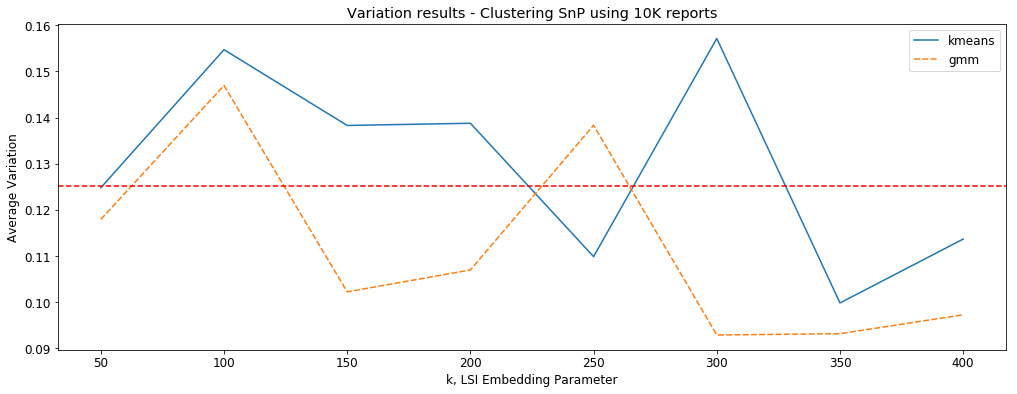

In [42]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Variation', title='Variation results - Clustering SnP using 10K reports')
plt.savefig('data_out/images/2_1.png')

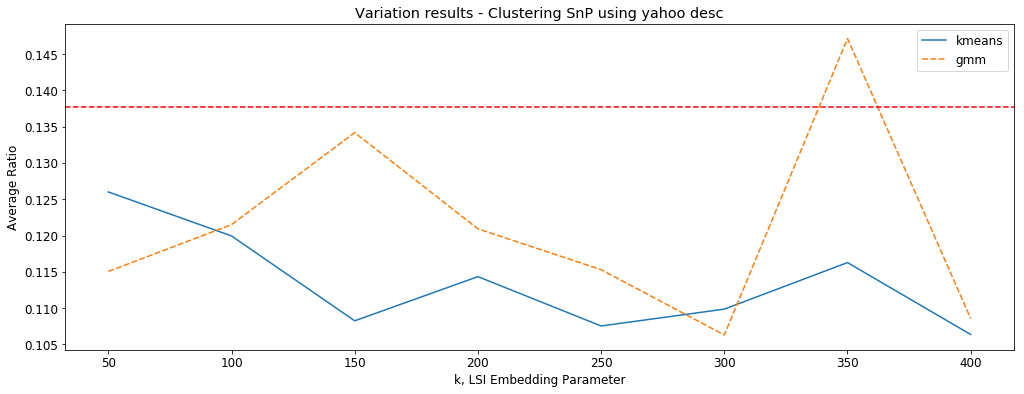

In [77]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Ratio', title='Variation results - Clustering SnP using yahoo desc')
plt.savefig('data_out/images/2_2.png')

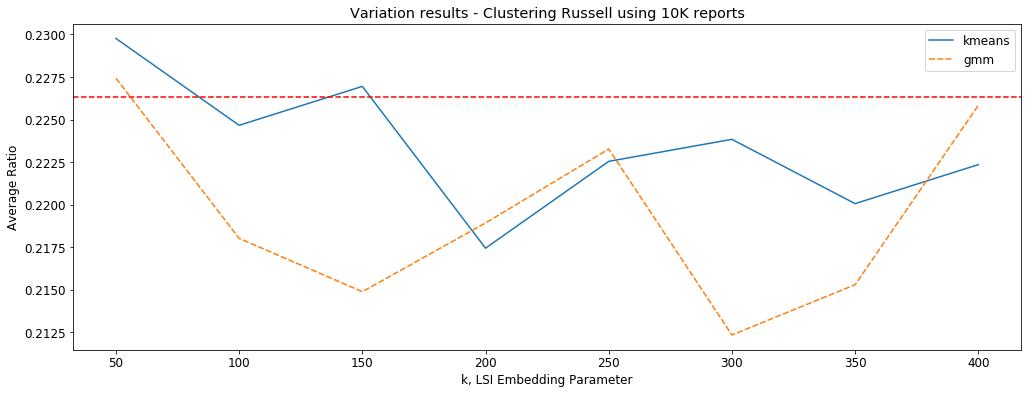

In [111]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Ratio', title='Variation results - Clustering Russell using 10K reports')
plt.savefig('data_out/images/2_3.png')

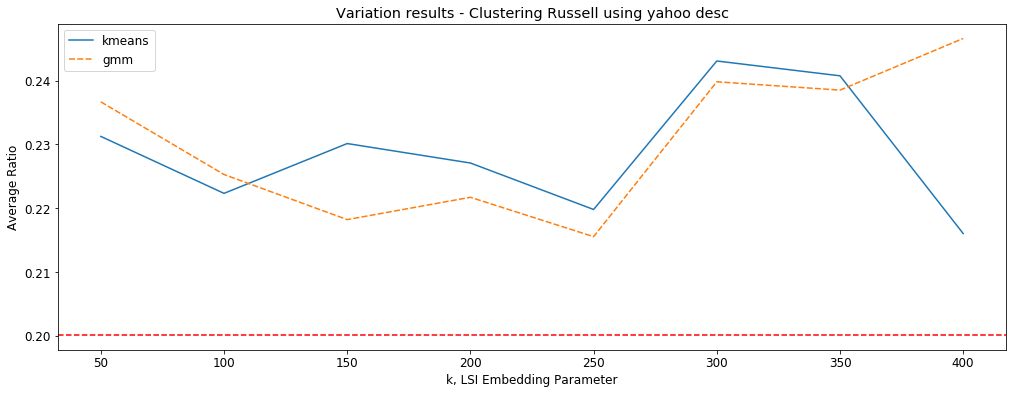

In [145]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Ratio', title='Variation results - Clustering Russell using yahoo desc')
plt.savefig('data_out/images/2_4.png')

### Method 2b - Absolute distances to cluster center (my method)

- not a good guage i think

In [ ]:
def cluster_distance(s):
    '''
    input: series
    output: sum(x - x_bar), sum of absolute distances to cluster center
    '''
    mean = s.mean() #ignores NaN values
    abs_dist = abs(s-mean).sum()
    return abs_dist

In [ ]:
RATIO_NAMES_LIST = list(ticker_ratios_df.columns[1:])
all_cluster_with_ratio = pd.merge(all_cluster_filtered, ticker_ratios_normalised_df, on='Ticker')
ratio_distances_dict = {}

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    
    filter_df = all_cluster_with_ratio[[cluster_mtd] + RATIO_NAMES_LIST]
    ratio_distance_sum = filter_df.groupby(cluster_mtd).aggregate(cluster_distance).sum()
    non_na_count_series = filter_df.count()[1:]
    ratio_distance_avg_list = list(ratio_distance_sum/non_na_count_series)
    ratio_distances_dict[cluster_mtd] = ratio_distance_avg_list
    
ratio_distances_df = pd.DataFrame.from_dict(ratio_distances_dict, orient='index', columns=RATIO_NAMES_LIST)

In [ ]:
ratio_distances_df['Average Ratio Cluster Spread'] = ratio_distances_df.mean(axis=1)
ratio_distances_df

In [ ]:
avg_ratio_df = ratio_distances_df[['Average Ratio Cluster Spread']]
GICS_RATIO = ratio_distances_df.loc['GICS', 'Average Ratio Cluster Spread']
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = avg_ratio_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd]  #(columns = {'test':'TEST'}, inplace = True) 
    list_of_dfs.append(mtd_df)

avg_ratio_pivot_df = pd.concat(list_of_dfs, axis=1)
print(GICS_RATIO)
avg_ratio_pivot_df

In [ ]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Ratio')

### Method 2b - Financial Ratio average cluster distance (averaged by mkt cap)

### Method 3a - Similarity to GICS by probability (among ticker with same GICS classification)

- probability that if GICS classifies 2 elements in the same industry, they are in the same categorisation in the clustering method
- if you include same or different industry similarity, the similarity scores will be very high because most of the time the classifications will be different
- in this case you can do the first method because the number of classes is fixed, so you cant put all as the same class

In [146]:
temp_df = pd.merge(all_cluster, all_cluster, on='GICS')
cross_df = temp_df[temp_df.Ticker_x != temp_df.Ticker_y]
similarity_dict = {}

for mtd in all_cluster.columns:
    if mtd not in ['Ticker', 'GICS']:
        mtd_x = mtd + '_x'
        mtd_y = mtd + '_y'
        similarity_dict[mtd] = sum(cross_df[mtd_x] == cross_df[mtd_y])/len(cross_df)

similarity_df = pd.DataFrame.from_dict(similarity_dict, orient='index', columns=['Similarity Probability'])

In [147]:
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = similarity_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd] 
    list_of_dfs.append(mtd_df)

similarity_pivot_df = pd.concat(list_of_dfs, axis=1)
similarity_pivot_df

,kmeans,gmm
50,0.301530,0.302560
100,0.341883,0.358963
150,0.295130,0.296619
200,0.282312,0.297601
250,0.348078,0.323062
300,0.326024,0.333360
350,0.251909,0.330191
400,0.278368,0.307519


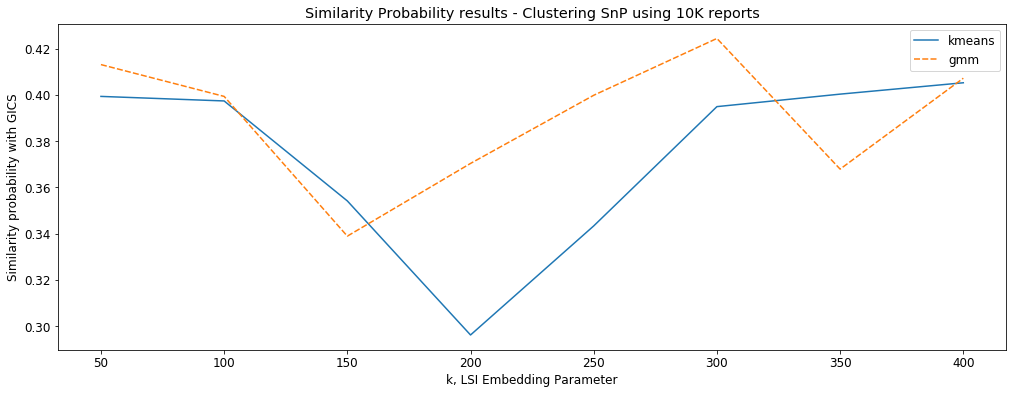

In [45]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering SnP using 10K reports')
plt.savefig('data_out/images/3_1.png')

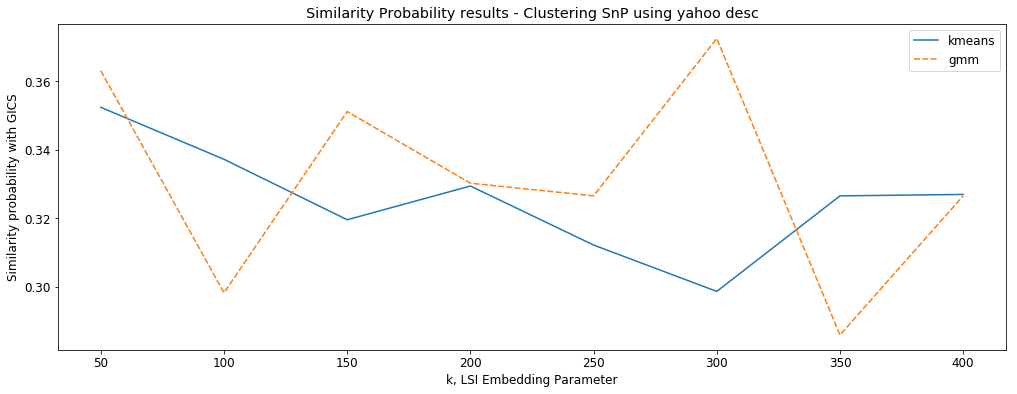

In [80]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering SnP using yahoo desc')
plt.savefig('data_out/images/3_2.png')

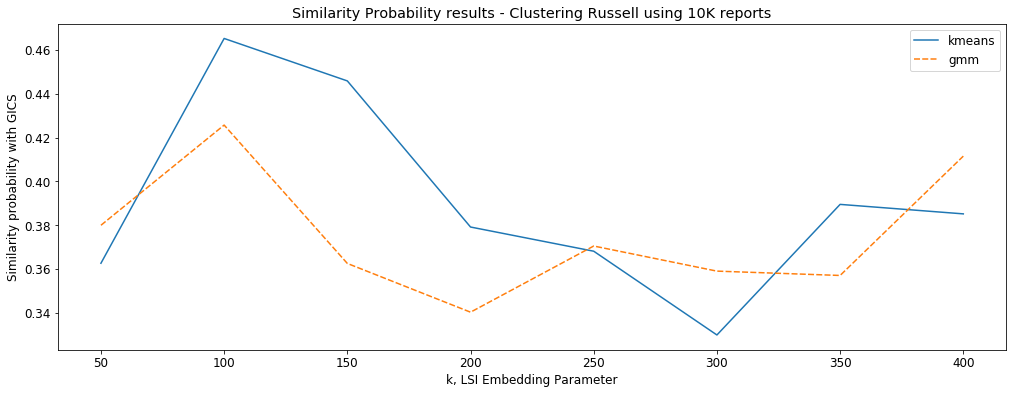

In [114]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering Russell using 10K reports')
plt.savefig('data_out/images/3_3.png')

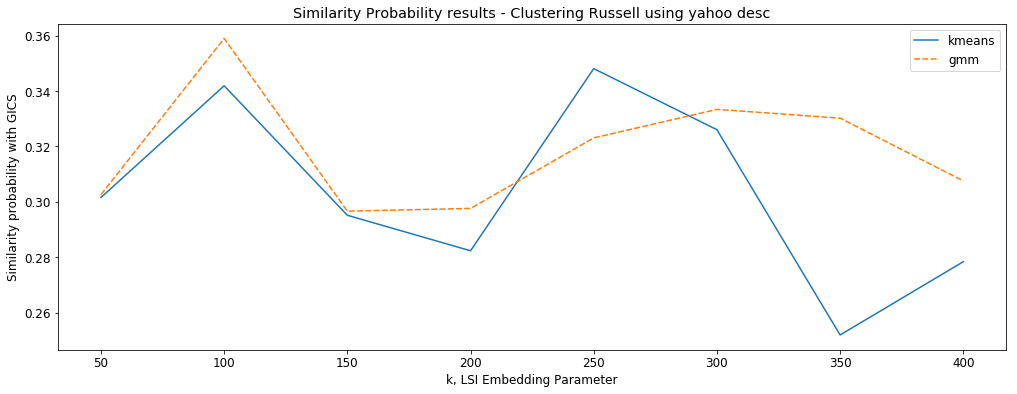

In [148]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering Russell using yahoo desc')
plt.savefig('data_out/images/3_4.png')

### Method 3b - Similarity to GICS by probability of similar classification type among ANY 2 tickers

- takes much longer

In [ ]:
L = len(all_cluster)
similarity_series = pd.Series(0, all_cluster.columns)

for i in tnrange(L):
    for j in range(L):
        if i != j:
            similarity = (all_cluster.iloc[i] == all_cluster.iloc[j])
            if not similarity.GICS:
                similarity = ~similarity
            similarity_series += similarity.astype(int)

In [ ]:
similarity_df = pd.DataFrame((similarity_series/similarity_series.GICS)[2:], columns=['Similarity Probability'])

In [ ]:
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = similarity_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd] 
    list_of_dfs.append(mtd_df)

similarity_pivot_df = pd.concat(list_of_dfs, axis=1)
similarity_pivot_df

In [ ]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS')

### Method 4 - Majority element ratios (my method)

In [ ]:
all_cluster.head()

In [ ]:
# Test
all_cluster[all_cluster.GICS == 3]

In [ ]:
def majority_element_proportion(s):
    '''
    input: series
    output: proportion of majority element in series
    '''
    l = len(s)
    n = s.value_counts().iloc[0]
    return n/l

In [ ]:
correctness_ratios_df = all_cluster.iloc[:,1:].groupby('GICS').aggregate(majority_element_proportion)

In [ ]:
correctness_ratios_df.plot.bar()
# sns.barplot(correctness_ratios_df)

In [ ]:
sns.distplot(correctness_ratios_df.iloc[:,0], bins=15)

- Since most of the ratios seem to be above the 0.5 ratio, the clustring seems to have clustered pretty closely to GICS standard

# Extra

### Tests

##### LSA Word Embedding (Test, Actual For loop is below)

In [ ]:
lsa = TruncatedSVD(200, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa) # normalisae so each vector is len 1

In [ ]:
pd.DataFrame(dtm_lsa).head()

### Random

In [ ]:
# Plotting for 2D
%pylab inline

xs = [w[0] for w in dtm_lsa]
ys = [w[1] for w in dtm_lsa]
xs, ys

figure()
plt.scatter(xs,ys)
xlabel('First principal component')
ylabel('Second principal component')
title('Plot of points against LSA principal components')

In [ ]:
def cosine_similarity(dtm):
    '''
    input: Doc Matrix
    output: list of lists indicating clusters
    '''
    corr = np.asarray(numpy.asmatrix(dtm_lsa) * numpy.asmatrix(dtm_lsa).T)
    
    L = dtm.shape[0]
    clusters = [[i] for i in range(L)]
    
    while (len(clusters) != NUM_INDUSTRIES):
        L = len(clusters)
        max_similarity = -1
        max_similarity_clusters = (None, None)
        for i in range(L):
            for j in range(i+1,L):
                cluster_1 = clusters[i]
                cluster_2 = clusters[j]
                n = len(cluster_1) * len(cluster_2)
                
                # Similarity
                total_similarity = 0
                for cpy_1 in cluster_1:
                    for cpy_2 in cluster_2:
                        print(cpy_1, cpy_2)
                        total_similarity += corr[cpy_1][cpy_2]
                similarity = total_similarity / n
                
                if similarity > max_similarity:
                    max_similarity = similarity 
                    max_similarity_clusters = (i, j)
        
        # Merge max_similarity clusters
        cluster_merge = clusters.pop(max_similarity_clusters[1])
        clusters[max_similarity_clusters[0]].append(cluster_merge)
        print(L)
    return clusters

|Embedding model|R2|proportion of right classification|
|----------------|--------|--------|
| LSI length 200 | 0.4537 | 0.4962 |
| LSI length 300 | 0.4459 | 0.4768 |
| LSI length 400 | 0.4421 | 0.4072 |
| LSI length 500 | 0.4554 | 0.4244 |
| LSI length 600 | 0.4362 | 0.4409 |
| LSI length 700 | 0.4407 | 0.3842 |
| LSI length 800 | 0.4417 | 0.4921 |
| LSI length 900 | 0.4478 | 0.4005 |
| LSI length 1000 | 0.4403 | 0.4068 |
| LSI length 1100 | 0.4380 | 0.3933 |